In [462]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import signal
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\labels.txt
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_

In [3]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [4]:
emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [231]:
emg_data2 = emg_data2.fillna({'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [578]:
def scale_data(data,scaler):
    X = data.iloc[:,3:]
    X = sc.fit_transform(X)
    data.iloc[:,3:] = X
    return data

def generate_window_slide_data(data,width = 256,stride = 32):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    sc = StandardScaler()
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                #x_sc = sc.fit_transform(np.array(data.iloc[i*stride:i*stride+width,3:]))
                #X += [x_sc]
                X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr

def compute_IEMG(data):
    IEMG = np.sum(np.abs(data),axis=1)
    return IEMG

def compute_MAV(data):
    N = data.shape[1]
    return np.sum(np.abs(data),axis=1)/N

def compute_SSI(data):
    return np.sum(np.power(data,2),axis=1)

def compute_VAR(data):
    N = data.shape[1]
    return compute_SSI(data)/(N-1)

def compute_RMS(data):
    N = data.shape[1]
    return np.sqrt(compute_SSI(data)/N)

def compute_WL(data):
    temp = data[:,1:,:]-data[:,:-1,:]
    return compute_IEMG(temp)

def compute_ZC(data,threshold=0):
    noise = 1e-2
    data = data+noise
    sign = ((data[:,1:,:])*(data[:,:-1,:]))<=-threshold
    sub = np.abs(data[:,1:,:]-data[:,:-1,:])>threshold
    return compute_IEMG(sign & sub)

def compute_SSC(data,threshold=0):
    temp = (data[:,1:-1,:]-data[:,:-2,:])*(data[:,1:-1,:]-data[:,2:,:])
    return compute_IEMG(temp >= threshold)

def compute_WAMP(data,threshold = 0):
    temp = np.abs(data[:,1:,:]-data[:,:-1,:])>=threshold
    return np.sum(temp,axis=1)

def compute_Skewness(data):
    return skew(data,axis=1)

def compute_Acti(data):
    N = data.shape[1]
    mean = np.mean(data,axis=1)
    return np.sum((data-mean[:,np.newaxis,:])**2,axis=1)/N

def generate_feature(data):
    IEMG = compute_IEMG(data)
    MAV = compute_MAV(data)
    SSI = compute_SSI(data)
    VAR = compute_VAR(data)
    RMS = compute_RMS(data)
    WL = compute_WL(data)
    ZC = compute_ZC(data)
    SSC = compute_SSC(data)
    WAMP = compute_WAMP(data,50)
    skew = compute_Skewness(data)
    Acti = compute_Acti(data)
    feature = np.concatenate([IEMG,MAV,SSI,VAR,RMS,WL,ZC,SSC,WAMP,skew,Acti],axis =1)
    return feature

In [534]:
feature.shape
#x

(2196, 80)

In [579]:
x,y = generate_window_slide_data(emg_data)
x2,y2 = generate_window_slide_data(emg_data2)

In [580]:
feature = generate_feature(x)
feature2 = generate_feature(x2)

In [416]:
pca = PCA(n_components=40,copy=True)
feature_pca = pca.fit_transform(feature)
feature2_pca = pca.transform(feature2)

In [445]:
np.mean(x[1,:,7])

1.1175871e-08

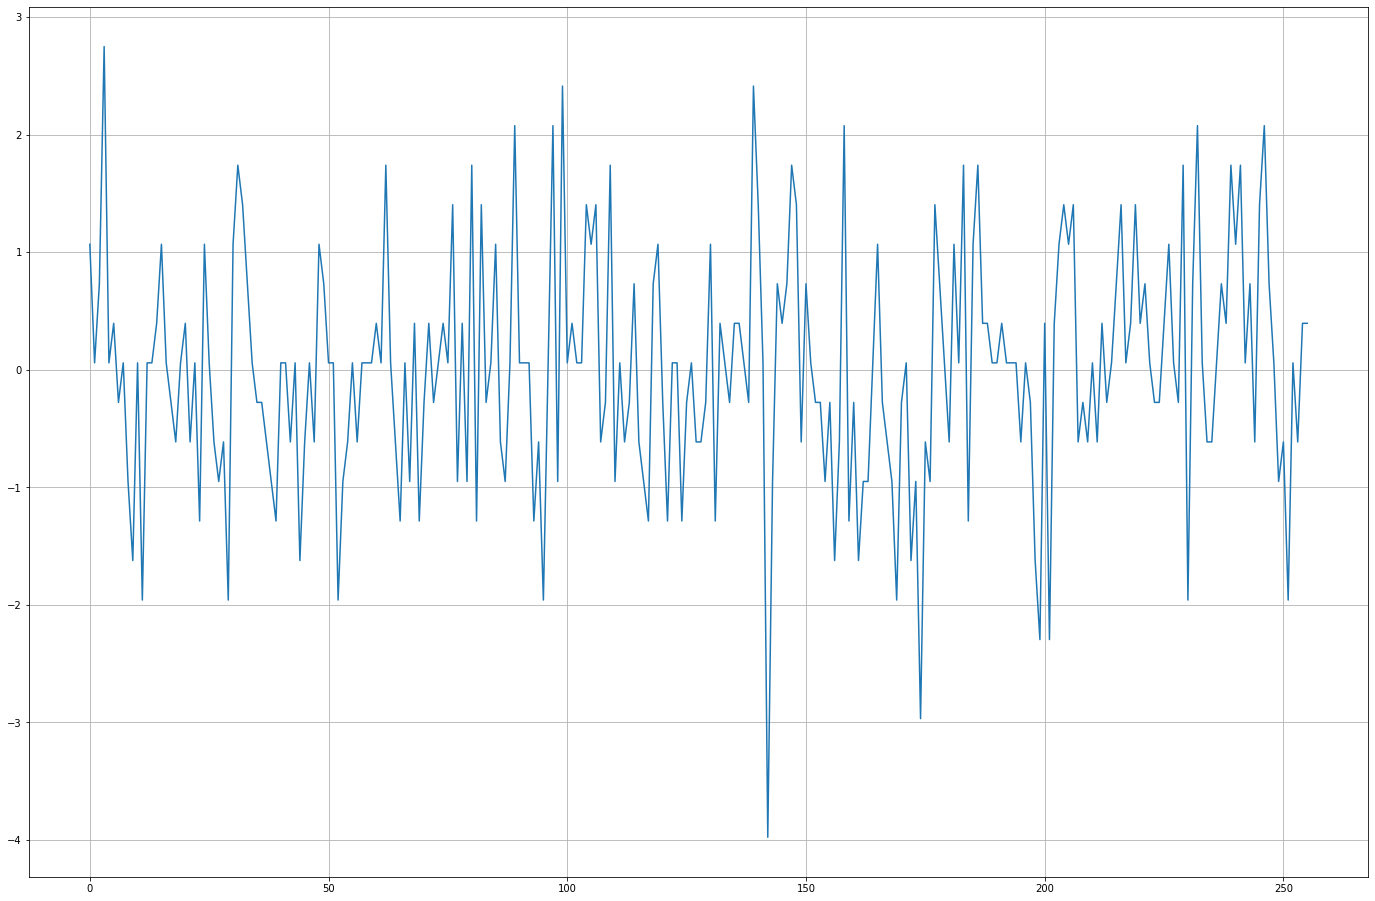

In [441]:
#plt.figure(figsize=(32,24))
plt.plot(x[1,:,3])
plt.grid(True)

In [537]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [589]:
ind = ((y==0)|(y==2))
ind_f = [0,1,6,42,46,57,62]
y_02 = y[ind]
y_02[y_02==2] = 1
oh_ec = OneHotEncoder()
y_oh = oh_ec.fit_transform(y[:,np.newaxis]).toarray()
x_train,x_valid,y_train,y_valid = train_test_split(feature[ind],y_02,test_size=0.2)
d_train = xgb.DMatrix(x_train,label=y_train)
d_valid = xgb.DMatrix(x_valid,label=y_valid)

In [596]:
param = {'max_depth': 4, 'eta': 0.5, 'silent': 0,'gamma':0.1, 'objective': 'multi:softmax'}
param['nthread'] = 4
param['seed'] = 100
param['num_class'] = 2
param['alpha'] = 2
#param['subsample'] = 0.8
evallist = [(d_valid, 'eval'), (d_train, 'train')]
model = xgb.XGBClassifier(max_depth=5, 
                          learning_rate=0.05, 
                          n_estimators=200, 
                          silent=True, 
                          eval_metrics='merror',
                          objective='binary:logistic', 
                          #objective='multi:softmax',
                          #num_calss=2,
                          seed=100,
                          nthread=4,
                          sub_sabsample=0.8
                          #gamma=0.1,
                         )
eval_set=[(x_train,y_train),(x_valid,y_valid)]
model.fit(x_train, y_train,eval_metric=['error'],eval_set=eval_set,early_stopping_rounds=25)
#model = xgb.train(param, d_train, 100, evallist)

[19:30:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.05658	validation_1-error:0.10354
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.04635	validation_1-error:0.07357
[2]	validation_0-error:0.05930	validation_1-error:0.06812
[3]	validation_0-error:0.04499	validation_1-error:0.05995
[4]	validation_0-error:0.04090	validation_1-error:0.04905
[5]	validation_0-error:0.03817	validation_1-error:0.04632
[6]	validation_0-error:0.03340	validation_1-error:0.03815
[7]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metrics='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='binary:logistic',
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=100, silent=True, sub_sabsample=0.8, subsample=1,
              tree_method='exact', ...)

In [597]:
y_pred=model.predict(x_valid)
metrics.accuracy_score(y_valid,y_pred)

0.9782016348773842

In [598]:
ind = ((y2==0)|(y2==2))
y_02 = y2[ind]
y_02[y_02==2] = 1
d_test = xgb.DMatrix(feature2_pca[ind],label=y_02)

In [600]:
y_pred=model.predict(feature2[ind])
metrics.accuracy_score(y_02,y_pred)

0.8343520782396088

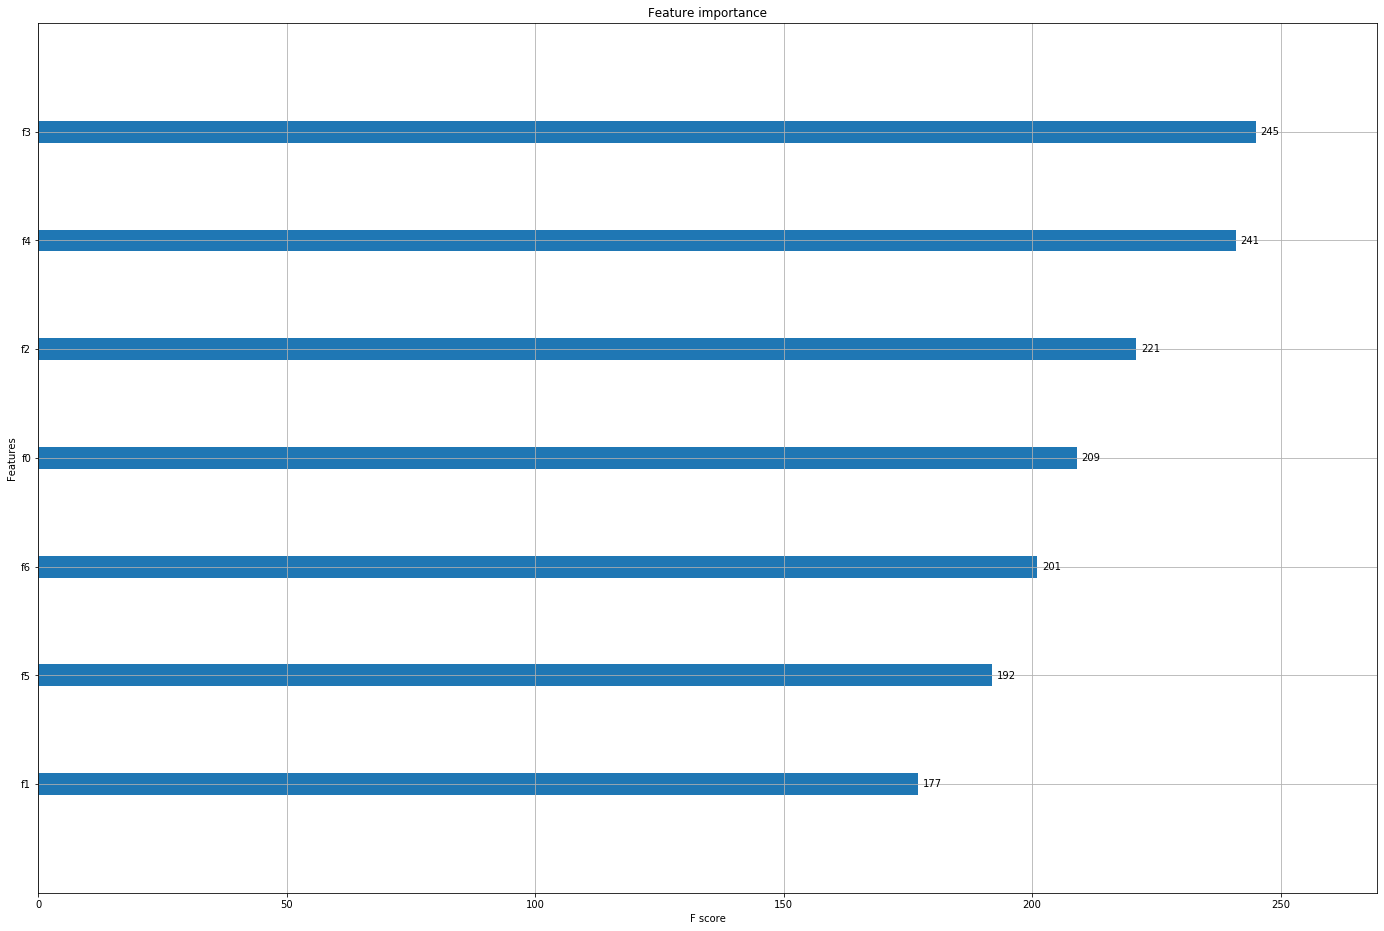

In [439]:
plt.rcParams["figure.figsize"] = (24,16)
plot_importance(model)
plt.show()

In [593]:
y_02[200]

1

In [436]:
feature[ind][:,ind_f].shape

(1834, 7)